# Reading 1D ecRad Output File. IWP Analysis

Version 6: 2023-07-17

Fixed parameters:

1. Radiative Transfer Model: ecRad
2. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
3. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
4. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
5. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
6. No gases and aerosols.
7. No liquid water.
8. Tropical Sounding Climatology (Temperature, Pressure and Specific Humidity) (Lapse Rate of $6.7\;K/km$ (see "1D_ecrad_input_creator_height_v6.ipynb")).

Variable parameters:
1. Macro: Temperature (Altitude-position) = 236 K, 218 K and 201 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro: Ice Water Path (IWP) = 0.1:0.1:1000 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{IWP}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$

4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib notebook

## Reading data

### ecRad output data

- 1O: Fu (Fu 1996 / Fu, Yang & Sun 1998)
- 2O: Yi (Yi et al. 2013)
- 3O: Baran2016 (Baran et al. 2016)
- 4O: Baran (Baran et al. 2014)

In [2]:
data_path = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
for pert in ['236','218','201']:
    for opt in range(1,5):
        file = 'output_1D_matrix_iwp_'+pert+'_'+str(opt)+'O1S_v6.nc'
        globals()['ecrad_out_'+pert+'_'+str(opt)+'O1S'] = xr.open_dataset(data_path+file)

### Tropical Profile

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_19654/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(ecrad_out_236_1O1S.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(ecrad_out_236_1O1S.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Cloud-radiative Heating (CRH) Rate matrix calculation:

Cloud-radiative Heating (CRH) rate in $K\;d^{-1}$ for each spectral component $i$ (SW and LW):

$$CRH_{i} \;=\; - \frac{g_0}{C_P}\frac{\partial }{\partial P}(CRE_{i})\;\;\frac{K}{s}\times\;86400\;\frac{s}{d}$$

where $g_0$ is the standard gravity acceleration ($9.8\;ms^{-2}$), $C_P$ is the specific heat capacity of dry air ($1080\;J kg^{-1} K^{-1}$) and $CRE_{i}$ is the Cloud Radiative Effect for each spectral component $i$ (SW and LW), computed as:

$$CRE_{i} \;=\; F_{All_{i}}^{NET} - F_{Clear_{i}}^{NET}$$

where $F^{NET}$ is the NET irradiance or flux ($Wm^{-2}$), computed as:

$$F_{i}^{NET} \;=\; F_{i}^{Downward} - F_{i}^{Upward}$$

The sign in the CRH equation is because of the definition of the outgoing fluxes as positive ??

In [6]:
rows_iwp = ecrad_out_236_1O1S.sizes['column']     # IWP (0.1 - 1000 g/m2)
prof     = ecrad_out_236_1O1S.sizes['half_level'] # Vertical Profile

## Heat capacity [J kg^-1 K^-1]:
cp = 1.08*10**(3)
## Volumetric heat capacity as ICON evaluates on model levels, not pl:
# cv = 0.718*10**3
## Gravity [m s^-2]:
g = 9.8

for pert in ['236','218','201']:
    ## Heating rates matrices [K day-1]:
    globals()['H_lw_'+pert] = np.zeros((4, rows_iwp, prof))
    globals()['H_sw_'+pert] = np.zeros((4, rows_iwp, prof))
    globals()['H_'+pert]    = np.zeros((4, rows_iwp, prof))

    ## Matrices for plotting:
    globals()['H_sw_'+pert+'_plot'] = np.zeros((4, prof, rows_iwp))
    globals()['H_lw_'+pert+'_plot'] = np.zeros((4, prof, rows_iwp))
    globals()['H_'+pert+'_plot']    = np.zeros((4, prof, rows_iwp))

    for opt in range(1,5): # per optical scheme
        ecrad_out = eval('ecrad_out_'+pert+'_'+str(opt)+'O1S')
        for i in range(rows_iwp):
            pres = ecrad_out.pressure_hl.values[i] # Pressure [Pa]

            # Net Fluxes [W m-2]
            lw_net_flux_cloudy = ecrad_out.flux_dn_lw.values[i] - ecrad_out.flux_up_lw.values[i]
            lw_net_flux_clear  = ecrad_out.flux_dn_lw_clear.values[i] - ecrad_out.flux_up_lw_clear.values[i]
            sw_net_flux_cloudy = ecrad_out.flux_dn_sw.values[i] - ecrad_out.flux_up_sw.values[i]
            sw_net_flux_clear  = ecrad_out.flux_dn_sw_clear.values[i] - ecrad_out.flux_up_sw_clear.values[i]

            # Cloud Radiative Effect [W m-2]
            lw_cre = lw_net_flux_cloudy - lw_net_flux_clear
            sw_cre = sw_net_flux_cloudy - sw_net_flux_clear
            
            # The sign is because of the definition of Outgoing fluxes as positive:
            # By using the diff function:
            #H_lw[opt-1,i,:] = -(g/cp)*(np.diff(lw_cre)/np.diff(pres))*86400 # K day^(-1)
            #H_sw[opt-1,i,:] = -(g/cp)*(np.diff(sw_cre)/np.diff(pres))*86400 # K day^(-1)
            # By using the gradient function:
            eval('H_lw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(lw_cre, pres))*86400 # K day^(-1)
            eval('H_sw_'+pert)[opt-1,i,:] = -(g/cp)*(np.gradient(sw_cre, pres))*86400 # K day^(-1)

        eval('H_'+pert)[opt-1,:,:] = eval('H_lw_'+pert)[opt-1,:,:] + eval('H_sw_'+pert)[opt-1,:,:]

        # For plotting:
        eval('H_sw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_sw_'+pert)[opt-1,:,:])
        eval('H_lw_'+pert+'_plot')[opt-1,:,:] = np.transpose(eval('H_lw_'+pert)[opt-1,:,:])
        eval('H_'+pert+'_plot')[opt-1,:,:]    = np.transpose(eval('H_'+pert)[opt-1,:,:])

#### Cloud Heating Rate (CRH) matrix for plotting (3 perturbations together):

In [7]:
## New Matrices for plotting:
H_sw_plot = np.zeros((4, prof, rows_iwp))
H_lw_plot = np.zeros((4, prof, rows_iwp))
H_plot    = np.zeros((4, prof, rows_iwp))

for pert in [236, 218, 201]:
    pert_i = (temp.iloc[tropopause_i:] - pert).abs().argmin() # iloc position
    i = tropopause_i + pert_i
#    if pert == 218: bottom_step = 5
#    else: bottom_step = 4
#     if pert == 236: top_step = 3
#     else: top_step = 4
    H_sw_plot[:,i-4:i+5,:] = eval('H_sw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_lw_plot[:,i-4:i+5,:] = eval('H_lw_'+str(pert)+'_plot')[:,i-4:i+5,:]
    H_plot[:,i-4:i+5,:] = eval('H_'+str(pert)+'_plot')[:,i-4:i+5,:]

 ### CRH vs IWP for top and bottom layer

In [8]:
iwp = np.arange(.1, 1000.1, .1)

<IPython.core.display.Javascript object>


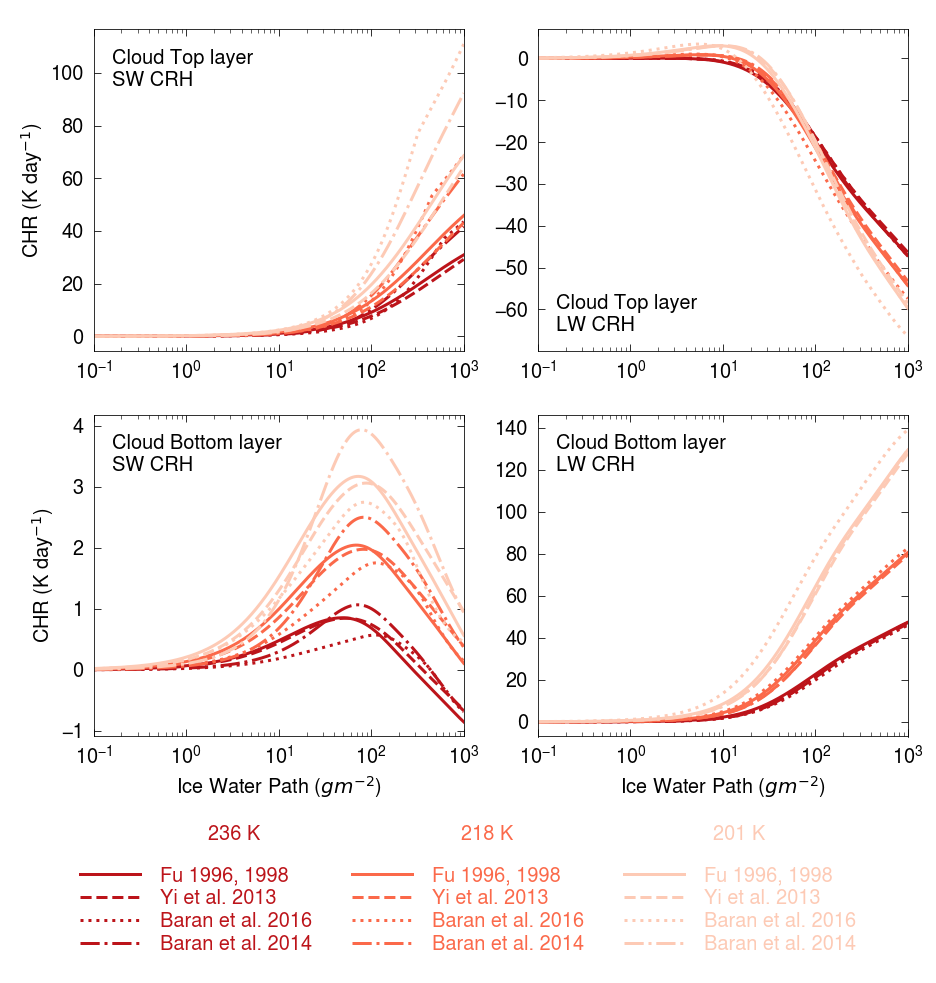

In [9]:
fontname = 'Nimbus Sans' # Arial
fontsize = 20
flength  = 13 # inches
fheigth  = flength*1.05 # inches

my_colors = [(88/255, 148/255, 197/255), (169/255, 23/255, 38/255),
             (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
             (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
             (107/255, 188/255, 233/255), 'grey']

rows    = 2
columns = 2
f, ax = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.97, bottom = 0.25, left = 0.1, right = 0.97, 
                    hspace = .2, wspace = .2)

# STRUCTURE:
# Frame 1x1: SW - Top layer
# Frame 1x2: LW - Top Layer
# Frame 2x1: SW - Bottom Layer
# Frame 2x2: LW - Bottom Layer
# Color per temperature. Linestyle per Scheme.

OptSch   = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
linestye = ['solid', 'dashed', 'dotted', 'dashdot']
handles  = []
labels   = []
for pert in [236,218,201]:
    perti        = (temp.iloc[tropopause_i:] - pert).abs().argmin() # iloc position
    perti_height = height_hl_pd.iloc[tropopause_i+perti] # middle point of cloud in terms of height
    # iloc positions of bottom and top layers:
    if pert == 218: lower_range = 1; upper_range = .75; # REPAIR THREE LEVEL MATRIX
    else: lower_range = .75; upper_range = 1
    bottom_hi    = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height - lower_range)].index[0])
    top_hi       = height_hl_pd.index.get_loc(height_hl_pd[height_hl_pd == (perti_height + upper_range)].index[0])
    for opt in range(4):
        color = matplotlib.cm.Reds(.8 - [236,218,201].index(pert)*.3)
        
        # SW, Top Layer:
        h = ax[0,0].plot(iwp, H_sw_plot[opt, top_hi, :],
                         linestyle = linestye[opt], 
                         linewidth = 3, color = color)
        handles = handles + h
        labels.append(OptSch[opt])
        #labels.append(str(pert) + ' K - ' + OptSch[opt])
        
        # LW, Top Layer:
        h2 = ax[0,1].plot(iwp, H_lw_plot[opt, top_hi, :],
                          linestyle = linestye[opt], 
                          linewidth = 3, color = color)
        # SW, Bottom Layer:
        h3 = ax[1,0].plot(iwp, H_sw_plot[opt, bottom_hi, :],
                          linestyle = linestye[opt], 
                          linewidth = 3, color = color)
        # LW, Bottom Layer:
        h3 = ax[1,1].plot(iwp, H_lw_plot[opt, bottom_hi, :],
                          linestyle = linestye[opt], 
                          linewidth = 3, color = color)
    
    f.text(0.25 + (0.27*[236,218,201].index(pert)), 0.15, str(pert) + ' K',
           ha = 'center', va = 'center', fontname = fontname, fontsize = fontsize,
           color = color)

#ax.grid('on', linestyle = 'dashed', color = 'grey', alpha = .4,
#        dashes = (8, 8), linewidth = .8)

# AXIS PARAMETERS
#X Axis
ax[1,0].set_xlabel(r'Ice Water Path ($gm^{-2}$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
ax[1,1].set_xlabel(r'Ice Water Path ($gm^{-2}$)', fontname = fontname, 
                   fontsize = fontsize, color = 'black', labelpad = 5)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xscale('log')
        #major_ticks_x = np.arange(-60, 1100, 10)
        #minor_ticks_x = np.arange(-60, 60, 5)
        #ax.set_xticks(major_ticks_x)
        #ax.set_xticks(minor_ticks_x, minor=True)
        ax[i,j].set_xlim(.1, 1000)
        ax[i,j].tick_params(axis = 'x', which = 'major', color = 'black',
                            size = 7, direction = 'in', top = True,
                            labelsize = fontsize, pad = 10)
        ax[i,j].tick_params(axis = 'x', which = 'minor',
                            color = 'black', size = 4,
                            direction = 'in', top = True)
        for tick in ax[i,j].get_xticklabels():
            tick.set_fontname(fontname)
    
#Y Axis
ax[0,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)
ax[1,0].set_ylabel('CHR (K day$^{-1}$)', fontname = fontname, fontsize = fontsize,
                   color = 'black', labelpad = 5)

for i in range(2):
    for j in range(2):
        #major_ticks_y = np.arange(-60, 1100, 10)
        #minor_ticks_y = np.arange(-60, 60, 5)
        #ax.set_xticks(major_ticks_y)
        #ax.set_xticks(minor_ticks_y, minor=True)
        #ax.set_xlim(-50, 50)
        ax[i,j].tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
        ax[i,j].tick_params(axis = 'y', which = 'minor', color = 'black',
               size = 4, direction = 'in', right = True)
        for tick in ax[i,j].get_yticklabels():
            tick.set_fontname(fontname)

# Additional Texts:
ax[0,0].text(0.05, 0.94, 'Cloud Top layer'+'\n'+'SW CRH',
             ha = 'left', va = 'top', transform = ax[0, 0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[0,1].text(0.05, 0.05, 'Cloud Top layer'+'\n'+'LW CRH',
             ha = 'left', va = 'bottom', transform = ax[0, 1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,0].text(0.05, 0.94, 'Cloud Bottom layer'+'\n'+'SW CRH',
             ha = 'left', va = 'top', transform = ax[1, 0].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')
ax[1,1].text(0.05, 0.94, 'Cloud Bottom layer'+'\n'+'LW CRH',
             ha = 'left', va = 'top', transform = ax[1, 1].transAxes,
             fontname = fontname, fontsize = fontsize, color = 'black')


# Legend:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
legend  = plt.legend(handles, labels, loc = 'lower center',
                     bbox_to_anchor = (.5, .01),
                     bbox_transform = f.transFigure,
                     frameon = False, ncol = 3, columnspacing = 2,
                     labelspacing = .2, labelcolor = 'linecolor',
                     handlelength = 3, handletextpad = 1,
                     prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_crh_iwp_1S_v6.png', dpi=500)

### Evaluating maximum values of CRH

Set range limit of IWP for figure:

In [10]:
range_lim = 1000
iwp       = np.arange(5, range_lim + 5, 5)

What was this for?

In [11]:
crh_lim = [H_lw_plot[0,:,:len(iwp)+2].max(),
           H_lw_plot[0,:,:len(iwp)+2].min(),
           H_lw_plot[2,:,:len(iwp)+2].max(),
           H_lw_plot[2,:,:len(iwp)+2].min(),
           H_lw_plot[1,:,:len(iwp)+2].max(),
           H_lw_plot[1,:,:len(iwp)+2].min()]

if min(crh_lim)%10 < 5: vmin = min(crh_lim) - min(crh_lim)%10
else: vmin = min(crh_lim) + (10 - min(crh_lim)%10)
if max(crh_lim)%10 < 5: vmax = max(crh_lim) - max(crh_lim)%10
else: vmax = max(crh_lim) + (10 - max(crh_lim)%10)

cbar_range = max([abs(vmin),abs(vmax)])

print('Fu max: ',H_lw_plot[0,:,:len(iwp)+2].max())
print('Fu min: ',H_lw_plot[0,:,:len(iwp)+2].min())
print('Yi max: ',H_lw_plot[2,:,:len(iwp)+2].max())
print('Yi min: ',H_lw_plot[2,:,:len(iwp)+2].min())
print('Baran max: ',H_lw_plot[1,:,:len(iwp)+2].max())
print('Baran min: ',H_lw_plot[1,:,:len(iwp)+2].min())

Fu max:  30.839562680598906
Fu min:  -5.362945579149211
Yi max:  44.97443426984413
Yi min:  -4.3170363608998645
Baran max:  27.963571311839186
Baran min:  -4.660260168764574


In [12]:
print('LW Fu max: ',H_lw_plot[0,:,:].max())
print('LW Fu min: ',H_lw_plot[0,:,:].min())
print('LW Yi max: ',H_lw_plot[1,:,:].max())
print('LW Yi min: ',H_lw_plot[1,:,:].min())
print('LW Baran2016 max: ',H_lw_plot[2,:,:].max())
print('LW Baran2016 min: ',H_lw_plot[2,:,:].min())
print('LW Baran2014 max: ',H_lw_plot[3,:,:].max())
print('LW Baran2014 min: ',H_lw_plot[3,:,:].min())
print('')
print('SW Fu max: ',H_sw_plot[0,:,:].max())
print('SW Fu min: ',H_sw_plot[0,:,:].min())
print('SW Yi max: ',H_sw_plot[1,:,:].max())
print('SW Yi min: ',H_sw_plot[1,:,:].min())
print('SW Baran2016 max: ',H_sw_plot[2,:,:].max())
print('SW Baran2016 min: ',H_sw_plot[2,:,:].min())
print('SW Baran2014 max: ',H_sw_plot[3,:,:].max())
print('SW Baran2014 min: ',H_sw_plot[3,:,:].min())
print('')
print('Fu max: ',H_plot[0,:,:].max())
print('Fu min: ',H_plot[0,:,:].min())
print('Yi max: ',H_plot[1,:,:].max())
print('Yi min: ',H_plot[1,:,:].min())
print('Baran2016 max: ',H_plot[2,:,:].max())
print('Baran2016 min: ',H_plot[2,:,:].min())
print('Baran2014 max: ',H_plot[3,:,:].max())
print('Baran2014 min: ',H_plot[3,:,:].min())

LW Fu max:  137.58439404676355
LW Fu min:  -69.18294826940841
LW Yi max:  137.79606754581425
LW Yi min:  -68.18039878916257
LW Baran2016 max:  140.76228996634597
LW Baran2016 min:  -72.73487536962669
LW Baran2014 max:  139.24855451029353
LW Baran2014 min:  -69.60466371960983

SW Fu max:  85.85050843141555
SW Fu min:  -1.2436457940773462
SW Yi max:  83.05626441213298
SW Yi min:  -1.231488070108643
SW Baran2016 max:  137.6879221389978
SW Baran2016 min:  -1.2547688713689542
SW Baran2014 max:  117.82481619120072
SW Baran2014 min:  -1.253018023507451

Fu max:  139.61680439017272
Fu min:  -16.172909915387432
Yi max:  140.85078572001177
Yi min:  -17.165010607064055
Baran2016 max:  142.6371054926657
Baran2016 min:  -14.503067681393773
Baran2014 max:  142.41407515883816
Baran2014 min:  -10.237909502430053


### Plotting CRH Matrix

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [14]:
xticks      = np.append(np.arange(0, len(iwp), int(len(iwp)/4)),len(iwp)-1)
xticks

array([  0,  50, 100, 150, 199])

<IPython.core.display.Javascript object>


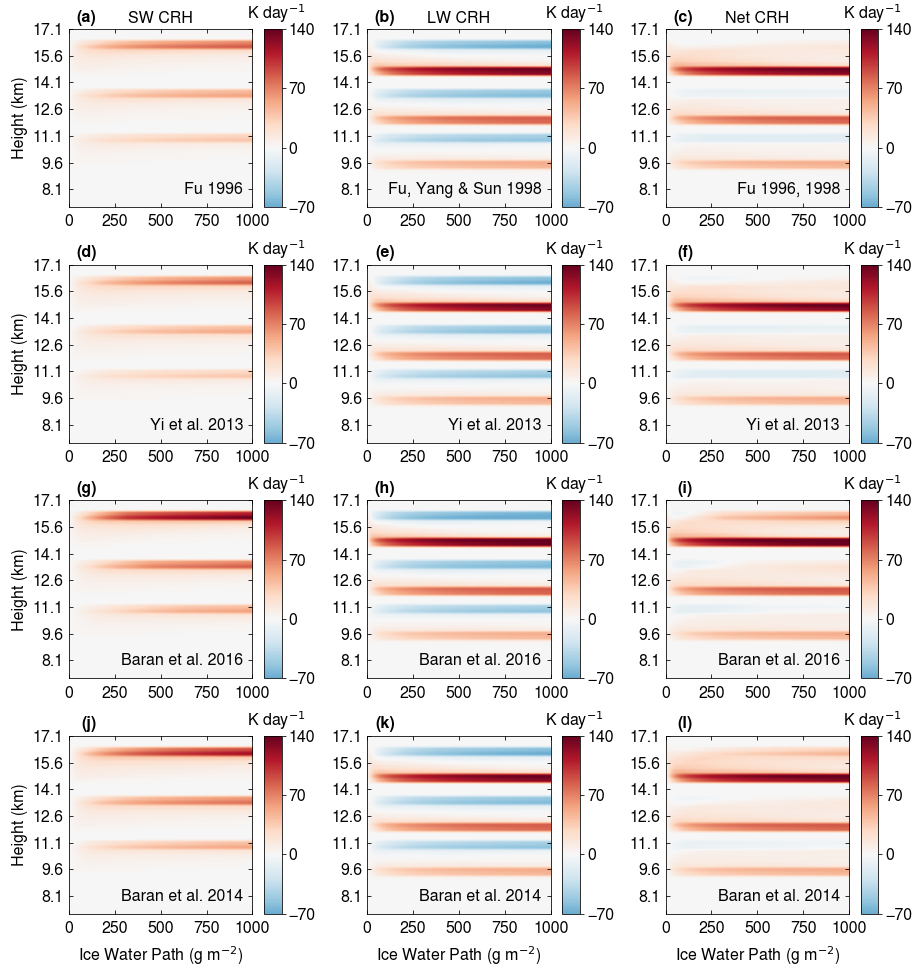

In [15]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13.5 # inches
flength  = 12.75 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.97, bottom = 0.06, left = 0.075, right = 0.975, 
                    hspace = .325, wspace = .3)

# COLORMAPS
vmini = -70
vmaxi = 140
tickbar = [vmini, 0, 70, vmaxi]

#For shortwave:
vmini_sw = -70
vmaxi_sw = 140
tickbar_sw = [vmini_sw, -0, 70, vmaxi_sw]

for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[opt], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[opt], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[opt], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_236.shape[2]+1, 6) # altitude tick labels
#yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()
#yticklabels = temp.loc[yticks].astype('int').to_list()  
    
# X Axis:
#xticks      = np.arange(0, 24, 6)
#xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

iwp         = np.arange(.1, 1000.1, .1)
xticks      = np.append(np.arange(0, len(iwp), int(len(iwp)/4)),len(iwp)-1)
#xticks      = xticks
xticklabels = iwp[xticks].round(0).astype('int')
#xticklabels = iwp[np.append(0, xticks[1:])]
#xticklabels_int = [0.1]
#for i in xticklabels[1:]:
#    xticklabels_int.append(int(i))
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Ice Water Path (g m$^{-2}$)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.05, OptSch_sw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.05, OptSch_lw[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.05, OptSch[opt],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_iwp_1S_absolute_v6b.png', dpi=500)

#### CRH in logarithmic scale

In [16]:
iwp[2000]

200.1

In [17]:
print('LW Fu max: ',H_lw_plot[0,:,:1999].max())
print('LW Fu min: ',H_lw_plot[0,:,:1999].min())
print('LW Yi max: ',H_lw_plot[1,:,:1999].max())
print('LW Yi min: ',H_lw_plot[1,:,:1999].min())
print('LW Baran2016 max: ',H_lw_plot[2,:,:1999].max())
print('LW Baran2016 min: ',H_lw_plot[2,:,:1999].min())
print('LW Baran2014 max: ',H_lw_plot[3,:,:1999].max())
print('LW Baran2014 min: ',H_lw_plot[3,:,:1999].min())
print('')
print('SW Fu max: ',H_sw_plot[0,:,:1999].max())
print('SW Fu min: ',H_sw_plot[0,:,:1999].min())
print('SW Yi max: ',H_sw_plot[1,:,:1999].max())
print('SW Yi min: ',H_sw_plot[1,:,:1999].min())
print('SW Baran2016 max: ',H_sw_plot[2,:,:1999].max())
print('SW Baran2016 min: ',H_sw_plot[2,:,:1999].min())
print('SW Baran2014 max: ',H_sw_plot[3,:,:1999].max())
print('SW Baran2014 min: ',H_sw_plot[3,:,:1999].min())
print('')
print('Fu max: ',H_plot[0,:,:1999].max())
print('Fu min: ',H_plot[0,:,:1999].min())
print('Yi max: ',H_plot[1,:,:1999].max())
print('Yi min: ',H_plot[1,:,:1999].min())
print('Baran2016 max: ',H_plot[2,:,:1999].max())
print('Baran2016 min: ',H_plot[2,:,:1999].min())
print('Baran2014 max: ',H_plot[3,:,:1999].max())
print('Baran2014 min: ',H_plot[3,:,:1999].min())

LW Fu max:  104.81878892172931
LW Fu min:  -42.12682651210154
LW Yi max:  102.70262687654134
LW Yi min:  -39.94764639319316
LW Baran2016 max:  117.10691686844622
LW Baran2016 min:  -52.458843849053075
LW Baran2014 max:  103.91687330527859
LW Baran2014 min:  -40.89182848063277

SW Fu max:  48.920008834436786
SW Fu min:  -1.0436203593803286
SW Yi max:  43.36020043046959
SW Yi min:  -0.9853293067954536
SW Baran2016 max:  75.65779632017951
SW Baran2016 min:  -1.0048504481120863
SW Baran2014 max:  63.9685997894241
SW Baran2014 min:  -1.044201867854934

Fu max:  110.97329845388995
Fu min:  -14.546672627459154
Yi max:  109.29501326999511
Yi min:  -15.715740253953872
Baran2016 max:  123.14573070198615
Baran2016 min:  -14.503067681393773
Baran2014 max:  111.87297267569872
Baran2014 min:  -10.237909502430053


<IPython.core.display.Javascript object>


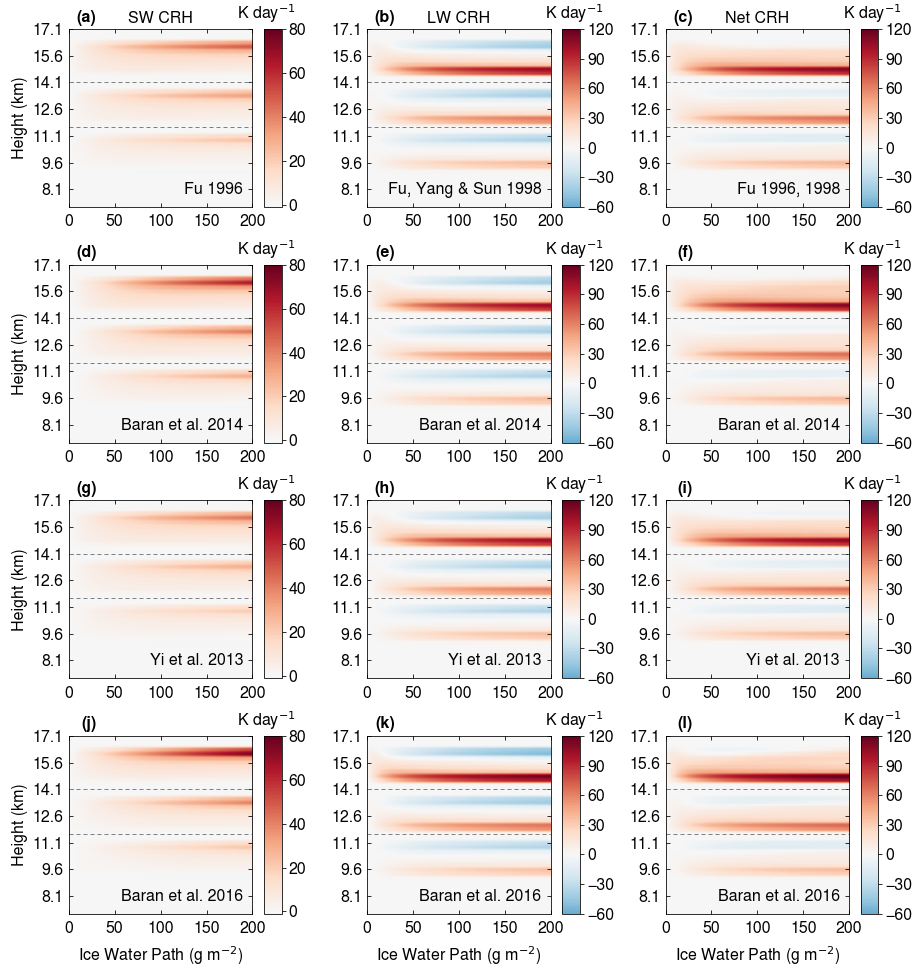

In [18]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 13.5 # inches
flength  = 12.75 # inches

rows    = 4
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.97, bottom = 0.06, left = 0.075, right = 0.975, 
                    hspace = .325, wspace = .3)

# COLORMAPS
vmini = -60
vmaxi = 120
tickbar = [vmini, -30, 0, 30, 60, 90, vmaxi]

#For shortwave:
vmini_sw = -1
vmaxi_sw = 80
tickbar_sw = [0, 20, 40, 60, vmaxi_sw]

Sch_order = [0, 3, 1, 2] # Fu, Baran 2014, Yi and Baran2016

for opt in range(rows):
    sch = Sch_order[opt]
    
    # Shortwave Heating Rate
    im = ax[opt, 0].imshow(H_sw_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw)) 
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 0].set_title('SW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[opt, 1].imshow(H_lw_plot[sch], cmap = 'RdBu_r', aspect = 'auto', 
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 1].set_title('LW CRH', color = 'black',
                             fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[opt, 2].imshow(H_plot[sch], cmap = 'RdBu_r', aspect = 'auto',
                           norm = MidpointNormalize(midpoint = 0, vmin = vmini, vmax = vmaxi))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar)
    cbar.set_label(r'K day$^{-1}$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if opt == 0:
        ax[opt, 2].set_title('Net CRH', color ='black',
                             fontsize = fontsize, fontname = fontname)
        
    ax[sch, 0].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 0].axhline((height_hl_pd - 14).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 1].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 1].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 2].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[sch, 2].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)

# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_236.shape[2]+1, 6) # altitude tick labels
#yticks      = np.arange(0, H.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()
#yticklabels = temp.loc[yticks].astype('int').to_list()  
    
# X Axis:
#xticks      = np.arange(0, 24, 6)
#xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

iwp         = np.arange(.1, 1000.1, .1)
xticks      = np.append(np.arange(0, len(iwp), int(len(iwp)/20)),len(iwp)-1)
#xticks      = xticks
xticklabels = iwp[xticks].round(0).astype('int')
#xticklabels = iwp[np.append(0, xticks[1:])]
#xticklabels_int = [0.1]
#for i in xticklabels[1:]:
#    xticklabels_int.append(int(i))
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    sch = Sch_order[opt]
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        if opt == 3:
            ax[opt, j].set_xlabel(r'Ice Water Path (g m$^{-2}$)', 
                                  fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 7.5)
        ax[opt, j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[opt, j].get_xticklabels():
            tick.set_fontname(fontname)
        # Log scale:
        #ax[opt, j].set_xscale('log')
        #ax[opt, j].set_xlim(-10, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))

        ax[opt, j].set_xticks(xticks)
        ax[opt, j].set_xticklabels(xticklabels) #[::-1]
        ax[opt, j].set_xlim(0, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))
        
        ax[opt, j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[opt, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[opt, j].set_yticks(yticks)
        ax[opt, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt, j].text(0.95, 0.05, OptSch_sw[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[opt, j].text(0.95, 0.05, OptSch_lw[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.05, OptSch[sch],
                            ha = 'right', va = 'bottom', transform = ax[opt, j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[opt, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[opt, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[opt, j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_iwp_1S_short_v6b_SM.png', dpi=500)

#### Plotting Differences Matrix

In [19]:
# Shortwave:
H_sw_diff_plot    = np.zeros((3, prof, rows_iwp))
H_sw_diff_plot[0] = H_sw_plot[1] - H_sw_plot[0] # Yi - Fu
H_sw_diff_plot[1] = H_sw_plot[2] - H_sw_plot[0] # Baran2016 - Fu
H_sw_diff_plot[2] = H_sw_plot[3] - H_sw_plot[0] # Baran2014 - Fu

# Longwave:
H_lw_diff_plot    = np.zeros((3, prof, rows_iwp))
H_lw_diff_plot[0] = H_lw_plot[1] - H_lw_plot[0] # Yi - Fu
H_lw_diff_plot[1] = H_lw_plot[2] - H_lw_plot[0] # Baran2016 - Fu
H_lw_diff_plot[2] = H_lw_plot[3] - H_lw_plot[0] # Baran2014 - Fu

# Net:
H_diff_plot    = np.zeros((3, prof, rows_iwp))
H_diff_plot[0] = H_plot[1] - H_plot[0] # Yi - Fu
H_diff_plot[1] = H_plot[2] - H_plot[0] # Baran - Fu
H_diff_plot[2] = H_plot[3] - H_plot[0] # Baran - Fu

In [20]:
# Shortwave CRH differences:
print('Shortwave CRH Differences:')
print('Yi - Fu max: ',H_sw_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_sw_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_sw_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_sw_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_sw_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_sw_diff_plot[2,:,:1999].min())

print('')
# Longwave CRH differences:
print('Longwave CRH Differences:')
print('Yi - Fu max: ',H_lw_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_lw_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_lw_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_lw_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_lw_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_lw_diff_plot[2,:,:1999].min())

print('')
# Net CRH differences:
print('Net CRH Differences:')
print('Yi - Fu max: ',H_diff_plot[0,:,:1999].max())
print('Yi - Fu min: ',H_diff_plot[0,:,:1999].min())
print('Baran2016 - Fu max: ',H_diff_plot[1,:,:1999].max())
print('Baran2016 - Fu min: ',H_diff_plot[1,:,:1999].min())
print('Baran2014 - Fu max: ',H_diff_plot[2,:,:1999].max())
print('Baran2014 - Fu min: ',H_diff_plot[2,:,:1999].min())

Shortwave CRH Differences:
Yi - Fu max:  0.46769325260860484
Yi - Fu min:  -5.559808403967196
Baran2016 - Fu max:  26.73778748574273
Baran2016 - Fu min:  -3.761891157776926
Baran2014 - Fu max:  15.048590954987311
Baran2014 - Fu min:  -1.3791898230597504

Longwave CRH Differences:
Yi - Fu max:  2.179597243048697
Yi - Fu min:  -3.753154898853687
Baran2016 - Fu max:  16.316443921680055
Baran2016 - Fu min:  -10.519527466434418
Baran2014 - Fu max:  2.184825429336719
Baran2014 - Fu min:  -3.6322303703116816

Net CRH Differences:
Yi - Fu max:  1.1825709695238231
Yi - Fu min:  -4.288171845350369
Baran2016 - Fu max:  16.40577014879119
Baran2016 - Fu min:  -7.85482646741673
Baran2014 - Fu max:  16.28358898645608
Baran2014 - Fu min:  -3.530604035387789


<IPython.core.display.Javascript object>


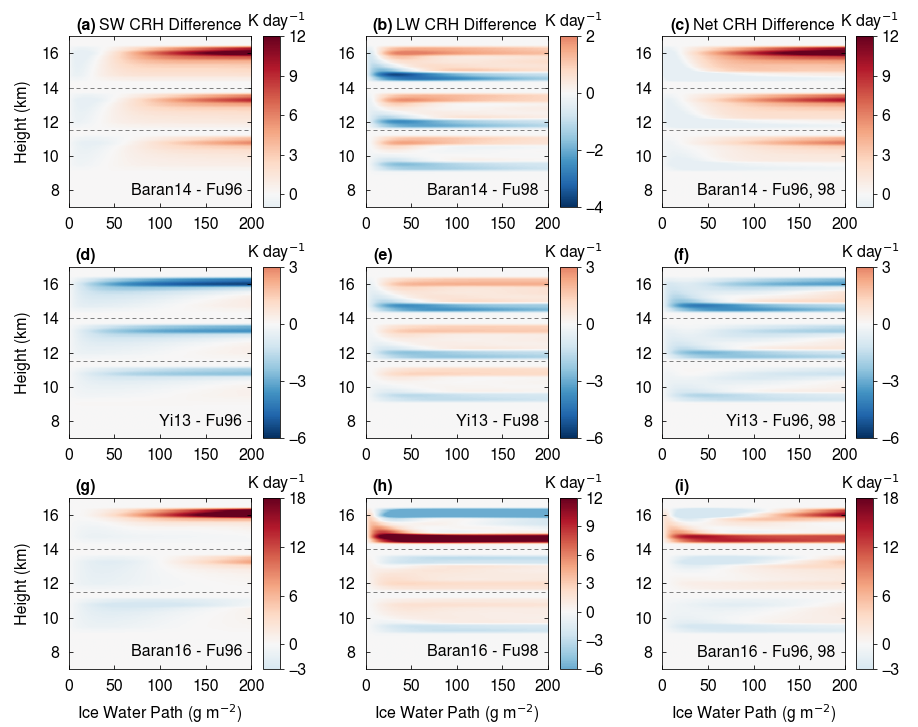

In [21]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 12.75 # inches

rows    = 3
columns = 3
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.075, right = 0.97, 
                    hspace = .35, wspace = .3)

IntSch_order = [2, 0, 1] # Baran2014 - Fu, Yi - Fu and Baran2016 - Fu

for diff in range(rows): 
    IntSch = IntSch_order[diff]
    if IntSch == 0: # Yi - Fu
        vmini_sw   = -6; vmaxi_sw = 3
        tickbar_sw = [vmini_sw, -3, 0, vmaxi_sw]
        vmini_lw   = -6; vmaxi_lw = 3
        tickbar_lw = [vmini_lw, -3, 0, vmaxi_lw]
        labelpad   = -30
    if IntSch == 1: # Baran2016 - Fu
        vmini_sw   = -3; vmaxi_sw = 18
        tickbar_sw = [vmini_sw, 0 , 6, 12, vmaxi_sw]
        vmini_lw   = -6; vmaxi_lw = 12
        tickbar_lw = [vmini_lw, -3, 0 , 3, 6, 9, vmaxi_lw]
        labelpad   = -30
    if IntSch == 2: # Baran2014 - Fu
        vmini_sw   = -1; vmaxi_sw = 12
        tickbar_sw = [0 , 3, 6, 9, vmaxi_sw]
        vmini_lw   = -4; vmaxi_lw = 2
        tickbar_lw = [vmini_lw, -2, 0 , vmaxi_lw]
        labelpad   = -30
    
    # Shortwave Heating Rate Difference
    im = ax[diff, 0].imshow(H_sw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title('SW CRH Difference', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(H_lw_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto', 
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_lw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title('LW CRH Difference', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)

    # Heating Rate
    im = ax[diff, 2].imshow(H_diff_plot[IntSch], cmap = "RdBu_r", aspect = 'auto',
                            norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = tickbar_sw)
    cbar.set_label(r'K day$^{-1}$', labelpad = labelpad, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 2].set_title('Net CRH Difference', color ='black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
    ax[IntSch, 0].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 0].axhline((height_hl_pd - 14).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 1].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 1].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 2].axhline((height_hl_pd - 11.5).abs().argmin(),
                       dashes=[4, 3], color = 'grey', linewidth = 1)
    ax[IntSch, 2].axhline((height_hl_pd - 14).abs().argmin(), 
                       dashes=[4, 3], color = 'grey', linewidth = 1)

        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, H_236.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
#xticks      = np.arange(0, 24, 6)
#xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

iwp         = np.arange(.1, 1000.1, .1)
xticks      = np.append(np.arange(0, len(iwp), int(len(iwp)/20)),len(iwp)-1)
#xticks      = xticks
xticklabels = iwp[xticks].round(0).astype('int')
#xticklabels = iwp[np.append(0, xticks[1:])]
#xticklabels_int = [0.1]
#for i in xticklabels[1:]:
#    xticklabels_int.append(int(i))
    
Diff_sw         = ['Yi13 - Fu96', 'Baran16 - Fu96', 'Baran14 - Fu96']
Diff_lw         = ['Yi13 - Fu98', 'Baran16 - Fu98', 'Baran14 - Fu98']
Diff            = ['Yi13 - Fu96, 98', 'Baran16 - Fu96, 98', 'Baran14 - Fu96, 98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows):
    IntSch = IntSch_order[diff]
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Ice Water Path (g m$^{-2}$)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
            
        # Log scale:
        #ax[opt, j].set_xscale('log')
        #ax[opt, j].set_xlim(-10, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].set_xlim(0, 2000) # In terms of bin (From position 1 (0.2 gm^2) to position 2000 (200.1 gm^2))
        
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.05, Diff_sw[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.05, Diff_lw[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[diff, j].text(0.95, 0.05, Diff[IntSch],
                             ha = 'right', va = 'bottom', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 7).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_iwp_diff_1S_v6d_paper.png', dpi=500)